# Cavern generation

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [18]:
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.minor.size"] = 0

## Read data layers

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Zones of interest

In [4]:
def plot_zones_map(zdf, dat_extent, dat_crs):
    """Plot zones of interest"""

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    ax = plt.axes(projection=ccrs.epsg(dat_crs))
    zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cx.add_basemap(
        ax, source=cx.providers.CartoDB.PositronNoLabels, crs=dat_crs
    )
    plt.title("Zones of interest")
    plt.tight_layout()
    plt.show()

In [5]:
# height = 120 m, 500 m <= depth <= 2,000 m
zones, _ = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000},
)

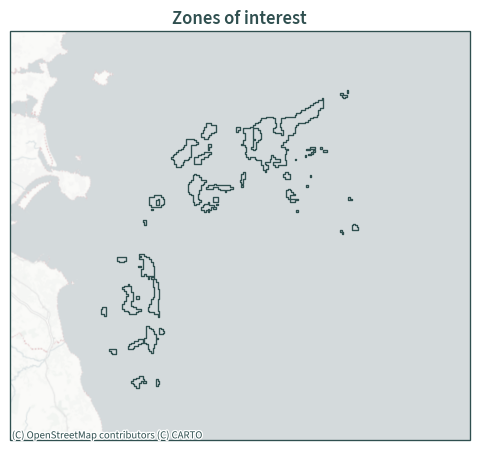

In [6]:
plot_zones_map(zones, extent, rd.CRS)

## Generate potential salt cavern locations

In [12]:
def plot_map(dat_xr, dat_extent, dat_crs, cavern_df, var, stat):
    """Helper function to plot halite and caverns within the zones of interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    cavern_df : cavern distribution
    var : variable
    stat : statistic (max / min / mean)
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(dat_crs))

    # cbar_label = (
    #     f"{dat_xr[var].attrs['long_name']} [{dat_xr[var].attrs['units']}]"
    # )

    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        # cbar_label = f"Maximum {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        # cbar_label = f"Minimum {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        # cbar_label = f"Mean {cbar_label}"

    plot_data[var].plot.contourf(
        cmap="jet",
        alpha=0.65,
        robust=True,
        levels=15,
        # cbar_kwargs={"label": cbar_label},
    )
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cavern_df.centroid.plot(
        ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
    )
    cx.add_basemap(ax, crs=dat_crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    ax.add_artist(
        ScaleBar(
            1,
            box_alpha=0,  # font_properties={"size": "large"},
            location="lower right",
            color="darkslategrey",
        )
    )
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05), markerscale=1.75)
    plt.title(None)
    plt.tight_layout()
    plt.show()

### Cavern calculations in a regular square grid

In [13]:
caverns = fns.generate_caverns_square_grid(dat_extent=extent, zones_df=zones)

In [14]:
len_square = len(caverns)

In [15]:
len_square

484

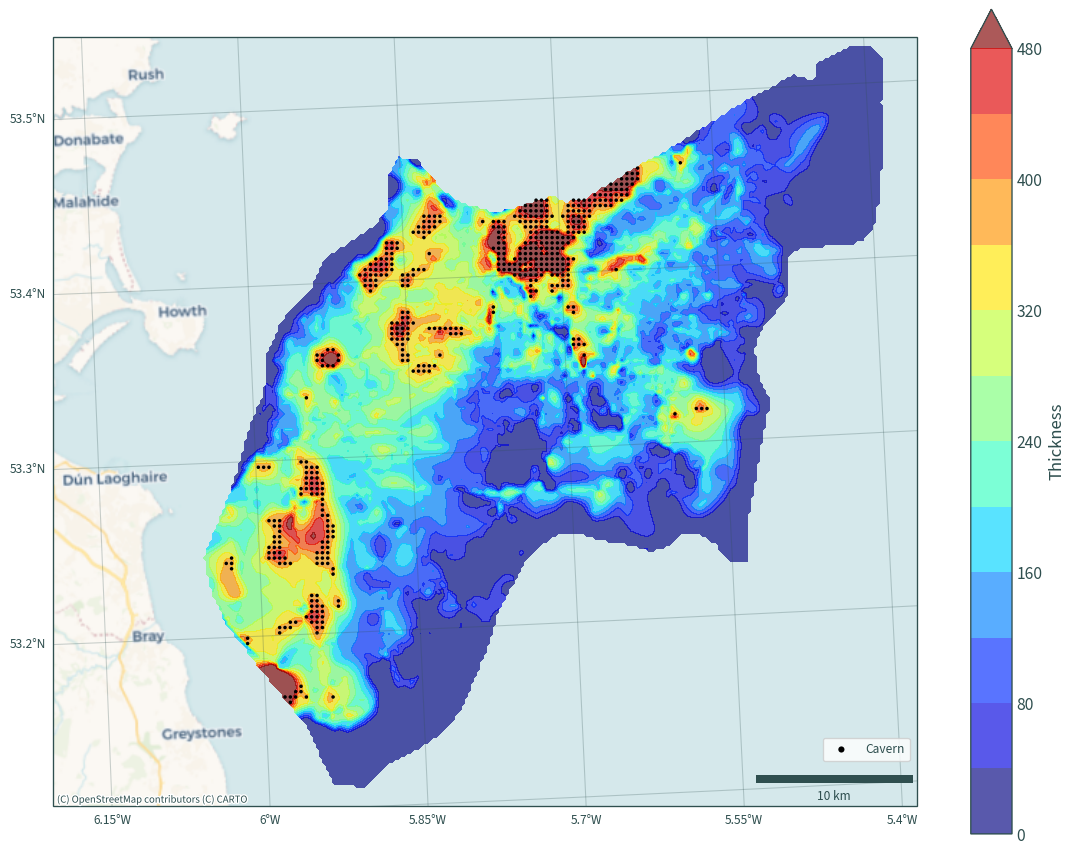

In [19]:
plot_map(ds, extent, rd.CRS, caverns, "Thickness", "max")

### Cavern calculations in a regular hexagonal grid

In [20]:
caverns = fns.generate_caverns_hexagonal_grid(
    dat_extent=extent,
    zones_df=zones,
)

In [21]:
len_hex = len(caverns)

In [22]:
len_hex

568

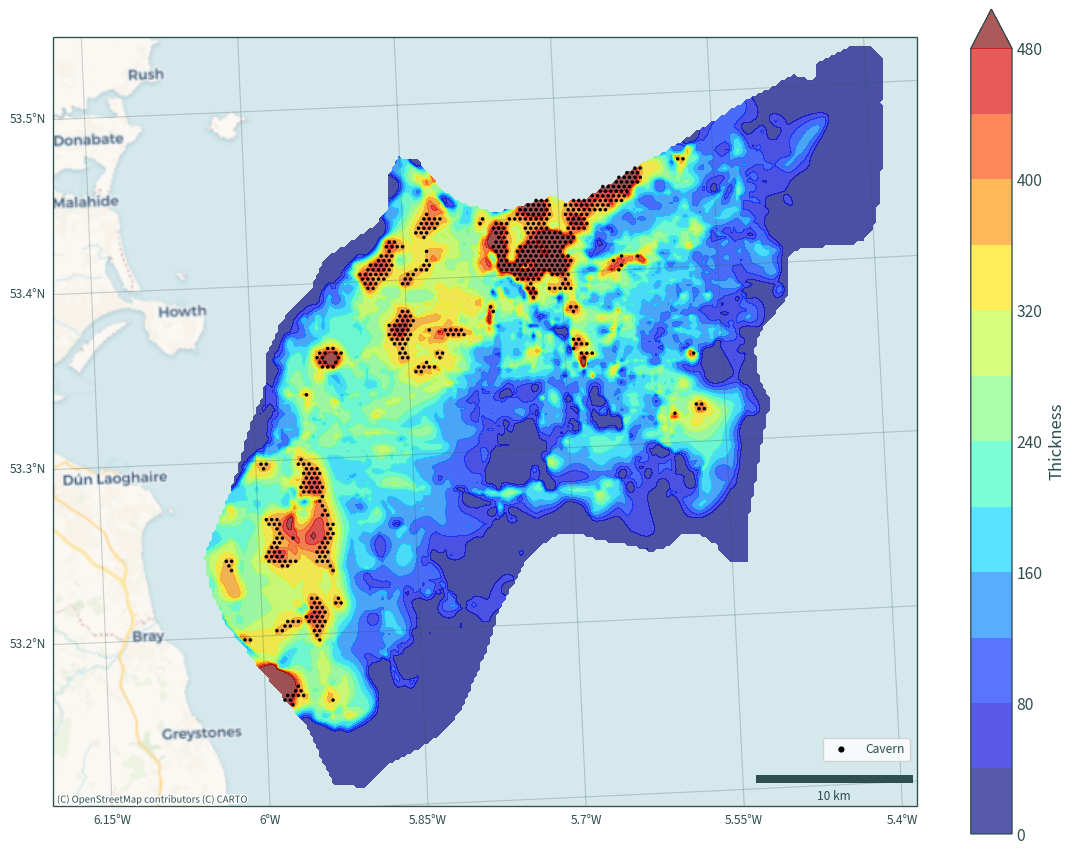

In [23]:
plot_map(ds, extent, rd.CRS, caverns, "Thickness", "max")

In [24]:
print(
    "Percentage increase in the number of caverns when using a regular "
    "hexagonal grid\nconfiguration compared to a square grid: "
    f"{(len_hex - len_square) / len_square * 100:.3f}%"
)

Percentage increase in the number of caverns when using a regular hexagonal grid
configuration compared to a square grid: 17.355%
